# Testing the code using Reduced Order Quadrature on simulated signal

This notebook provides tests of the `lalapps_pulsar_parameter_estimation_nested` code running normally and running using a Reduced Order Quadrature (ROQ) to produce an approximation of the likelihood. Here I run the code over a small range in frequency and frequency derivative.

To do the comparisons the code is run in its standard configuration and then run with the likelihood calculated using the ROQ approximations.

In [1]:
# import required modules

%matplotlib inline

from __future__ import print_function, division

import numpy as np
from scipy.signal import fftconvolve
import subprocess as sp
import os
import sys
import gzip
from time import time
import h5py

from scotchcorner import scotchcorner

# these modules require lalapps
from lalapps.pulsarpputils import *

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

In [2]:
# set up the run directories
rundir = '.'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detector = 'H1'        # the detector to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# fake heterodyned data directory (for the lalapps_pulsar_parameter_estimation code
# this must be dataDET, where DET is e.g. H1)
datadir = os.path.join(rundir, 'data'+detector)
if not os.path.isdir(datadir): # make the directory
    os.makedirs(datadir)

# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'local' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples
ppeexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation')

## Running the codes

The code is run on random Gaussian noise with zero mean and a given standard deviation. The prior file adds frequency `F0` and first frequency derivative `F1` parameters and assumes Gaussian prior distributions on these.

I output a comparison plot between the posteriors produced with and without the ROQ. I compare the upper limits, evidences and maximum likelihoods produced by each method. I also compare the run times for each implementation of the code.

In [3]:
# set up some general inputs

# create a pulsar parameter (TEMPO-stype .par file) file format string
pardat = """PSRJ J0000+0000
RAJ {}
DECJ {}
F0 123.4567890
F1 -1.0e-12
PEPOCH 56789.0
EPHEM DE405
"""

# some defaults for the data generation
sigma = 1.0e-22        # set data standard deviation
dt = 60                # number of seconds between data points
gpsstart = 1125969920  # GPS start time of data (over a year after the pulsar period epoch)
duration = 86400      # duration of data (seconds) - 1 days
gpstimes = np.arange(gpsstart, gpsstart+duration, dt) # time stamps
dlen = len(gpstimes)   # length of data

# get an estimate of the 95% credible upper limit to be expected
ulest = 10.8*np.sqrt(sigma**2/dlen)

# create the signal
pardict = {}
pardict['h0'] = sigma
pardict['psi'] = -np.pi/4. + np.random.rand()*np.pi/2. # get random polarisation angle
pardict['cosiota'] = -1. + 2.*np.random.rand() # get random inclination
pardict['phi0'] = np.pi*np.random.rand() # get random rotational phase

# create a random sky position from a uniform distribution on the sky
pardict['ra'] = 2.*np.pi*np.random.rand()
pardict['dec'] = np.arccos(-1.+2.*np.random.rand()) - np.pi/2.

# set the required SNR of the signal
snr = 5.

# generate signal
tssig, sig = heterodyned_pulsar_signal(gpsstart, duration, dt, detector, pardict)

# calculate SNR
snropt = get_optimal_snr(sig[0], sigma)

# scale signal to required SNR
sig[0] = sig[0]*(snr/snropt)

h0true = ulest*(snr/snropt) # the new h0 value

# upper range of prior
h0max = h0true + ulest*6.

# create the prior file for the lalapps_pulsar_parameter_estimation_nested code
# the F0 and F1 parameters have Gaussian prior distributions
f0mu = 123.4567890
f0sigma = 1e-6
f1mu = -1e-12
f1sigma = 1e-13

priorfile = os.path.join(rundir, 'pulsar.prior')
priordat = """H0 uniform 0 {}
PHI0 uniform 0 {}
PSI uniform 0 {}
COSIOTA uniform -1 1
F0 gaussian {:.7f} {:.1e}
F1 gaussian {:.1e} {:.1e}
"""
fp = open(priorfile, 'w')
# set the h0 upper range to be 6 times the expected upper limit 
fp.write(priordat.format(ulest*6., np.pi, np.pi/2., f0mu, f0sigma, f1mu, f1sigma))
fp.close()

# lalapps_pulsar_parameter_estimation_nested run parameters
Nlive = '2048' # number of nested sample live points

# ROQ setup
ntraining = '2500'     # the number of training models to form the reduced basis
roqtolerance = '1e-10' # the maximum allowed residuals between the training set and reduced basis
roqfile = os.path.join(datadir, 'roq.bin') # a file to output the ROQ intepolants and nodes

In [12]:
# create data
data = sigma*np.random.randn(dlen, 2)

# add signal to data
data[:,0] = data[:,0] + sig[0].real
data[:,1] = data[:,1] + sig[0].imag

# append times and data together
tad = np.vstack((gpstimes, data.T)).T

# output fake data
datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')
    
# create a random sky position from a uniform distribution on the sky
rah, ram, ras = rad_to_hms(pardict['ra'])
decd, decm, decs = rad_to_dms(pardict['dec'])

# output .par file containing right ascension and declination
parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat.format(coord_to_string(rah, ram, ras), coord_to_string(decd, decm, decs)))
fp.close()
    
# run lalapps_pulsar_parameter_estimation_nested in its standard mode
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outhdf', os.path.join(outdir, 'fake_nest.hdf'),
                     '--Nlive', Nlive, '--Nmcmcinitial', '0'])
t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timenested = (t1-t0)
    
# nested samples need to be converted to posterior samples with lalapps_nest2pos
codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post.hdf'),
                     os.path.join(outdir, 'fake_nest.hdf')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# get h0 upper limit
post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post.hdf'))
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=0.95)
    
h0ulnested = (h0ul)
evratnested = (evsig-evnoise)

# get the maximum likelihood
evfile = h5py.File(os.path.join(outdir, 'fake_nest.hdf'), 'r')
maxlike = evfile['lalinference']['lalinference_nest'].attrs['log_max_likelihood']
evfile.close()

# run lalapps_pulsar_parameter_estimation using the ROQ (first run to generate the ROQ)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outhdf', os.path.join(outdir, 'fake_nest_roq.hdf'),
                     '--Nlive', Nlive, '--Nmcmcinitial', '0', '--roq', '--roq-tolerance',
                     roqtolerance, '--ntraining', ntraining, '--output-weights', roqfile])

t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timegenerateroq = (t1-t0)

# run lalapps_pulsar_parameter_estimation using the ROQ (using pregenerated ROQ)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outhdf', os.path.join(outdir, 'fake_nest_roq.hdf'),
                     '--Nlive', Nlive, '--Nmcmcinitial', '0', '--roq', '--input-weights', roqfile])

t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timeroq = (t1-t0)

# nested samples need to be converted to posterior samples with lalapps_nest2pos
codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post_roq.hdf'),
                     os.path.join(outdir, 'fake_nest_roq.hdf')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# get h0 upper limit
postroq, evsigroq, evnoiseroq = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post_roq.hdf'))
h0ulroq = upper_limit_greedy(postroq['h0'].samples, upperlimit=0.95)
    
h0ulnestedroq = (h0ulroq)
evratnestedroq = (evsigroq-evnoiseroq)

# get the maximum likelihood
evfileroq = h5py.File(os.path.join(outdir, 'fake_nest_roq.hdf'), 'r')
maxlikeroq = evfileroq['lalinference']['lalinference_nest'].attrs['log_max_likelihood']
evfileroq.close()

Read columns [u'COSIOTA', u'F0', u'F1', u'H0', u'PHI0', u'PSI', u'deltalogL', u'deltaloglH1', u'logL', u'logPrior', u'logw', u'HSCALARL', u'POSEPOCH', u'DIST', u'PHI21', u'I21', u'PSITENSOR', u'HSCALARB', u'PHI0TENSOR', u'HCROSS', u'PHI0VECTOR', u'PHI22', u'PMDEC', u'DEC', u'COSTHETA', u'RA', u'IOTA', u'CGW', u'C22', u'C21', u'df', u'I31', u'THETA', u'PSIVECTOR', u'PEPOCH', u'PMRA', u'HPLUS', u'PSISCALAR', u'FREQNUM', u'Q22', u'HVECTORY', u'HVECTORX', u'PHI0SCALAR', u'LAMBDA']
Read columns [u'COSIOTA', u'F0', u'F1', u'H0', u'PHI0', u'PSI', u'deltalogL', u'deltaloglH1', u'logL', u'logPrior', u'logw', u'HSCALARL', u'POSEPOCH', u'DIST', u'PHI21', u'I21', u'PSITENSOR', u'HSCALARB', u'PHI0TENSOR', u'HCROSS', u'PHI0VECTOR', u'PHI22', u'PMDEC', u'DEC', u'COSTHETA', u'RA', u'IOTA', u'CGW', u'C22', u'C21', u'df', u'I31', u'THETA', u'PSIVECTOR', u'PEPOCH', u'PMRA', u'HPLUS', u'PSISCALAR', u'FREQNUM', u'Q22', u'HVECTORY', u'HVECTORX', u'PHI0SCALAR', u'LAMBDA']


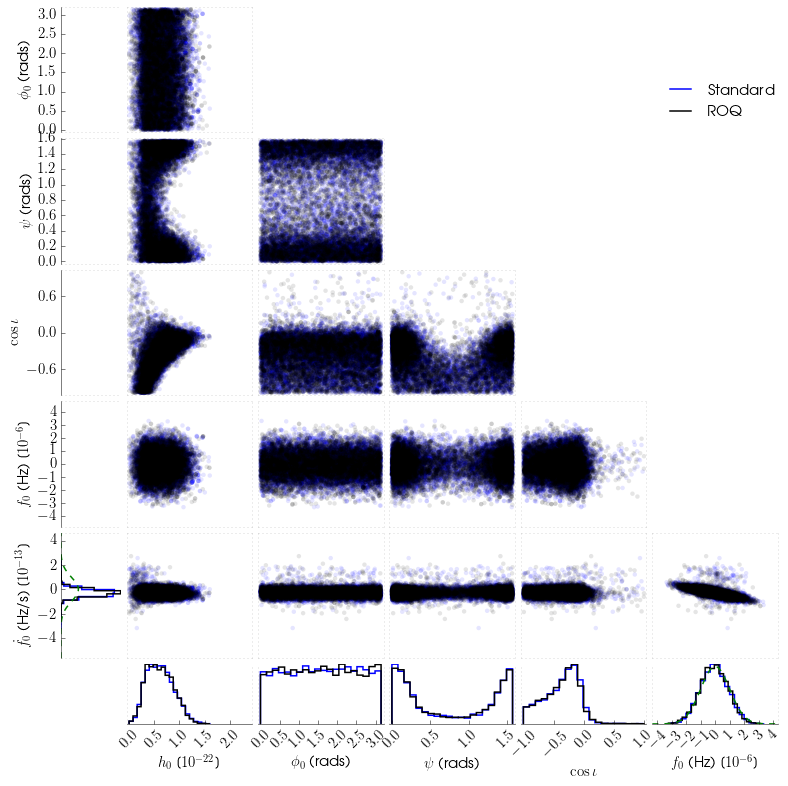

In [13]:
params = ['h0', 'phi0', 'psi', 'cosiota', 'f0', 'f1']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
postppenroq = np.zeros((len(postroq['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]
    postppenroq[:,i] = postroq[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = ['$h_0$', '$\phi_0$ (rads)', '$\psi$ (rads)', '$\cos{\iota}$', '$f_0$ (Hz)', '$\dot{f}_0$ (Hz/s)']
limits = [(0., None), (0., np.pi), (0., np.pi/2.), (-1., 1.), (None, None), (None, None)]

# subtract means from f0 and f1
postppen[:,params.index('f0')] = postppen[:,params.index('f0')] - f0mu
postppen[:,params.index('f1')] = postppen[:,params.index('f1')] - f1mu
postppenroq[:,params.index('f0')] = postppenroq[:,params.index('f0')] - f0mu
postppenroq[:,params.index('f1')] = postppenroq[:,params.index('f1')] - f1mu

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, datatitle='Standard', showlims='both', hist_kwargs=histops,
                  showcontours=False, limits=limits, showpoints=True, scatter_kwargs={'alpha': 0.1})
# add the ROQ run
histops = {'histtype': 'step', 'color': 'k', 'linewidth': 1.5}
sc.add_data(postppenroq, hist_kwargs=histops, datatitle='ROQ', showcontours=False, scatter_kwargs={'alpha': 0.1}, limits=limits)

# add F0 and F1 prior distributions
from scipy.stats import norm
axf0 = sc.get_axis('$f_0$ (Hz)')
f0range = np.linspace(axf0.get_xlim()[0], axf0.get_xlim()[1], 100)
axf0.plot(f0range, norm.pdf(f0range, 0, f0sigma), 'g--', lw=1.5)

axf1 = sc.get_axis('$\dot{f}_0$ (Hz/s)')
f1range = np.linspace(axf1.get_ylim()[0], axf1.get_ylim()[1], 100)
axf1.plot(norm.pdf(f1range, 0, f1sigma), f1range, 'g--', lw=1.5)


In [14]:
print("Difference in upper limits:")
print("h0 upper limit (standard) = %.2e" % h0ulnested)
print("h0 upper limit (ROQ) = %.2e" % h0ulnestedroq)
print("\n")
print("Difference in evidence ratios:")
print("log(evidence ratio) (standard) = %.3f" % evratnested)
print("log(evidence ratio) (ROQ) = %.3f" % evratnestedroq)
print("\n")
print("Difference in maximum likelihood values:")
print("log(max. likelihood) (standard) = %.4f" % maxlike)
print("log(max. likelihood) (ROQ) = %.4f" % maxlikeroq)
print("\n")
print("Difference in code run times:")
print("run time (standard) = %.4f" % timenested)
print("run time (ROQ) = %.4f" % timeroq)
print("time to generate ROQ = %.4f" % timegenerateroq)

Difference in upper limits:
h0 upper limit (standard) = 1.09e-22
h0 upper limit (ROQ) = 1.07e-22


Difference in evidence ratios:
log(evidence ratio) (standard) = 2.187
log(evidence ratio) (ROQ) = 2.173


Difference in maximum likelihood values:
log(max. likelihood) (standard) = 141795.3954
log(max. likelihood) (ROQ) = 141795.4264


Difference in code run times:
run time (standard) = 1148.6408
run time (ROQ) = 772.1321
time to generate ROQ = 130.4941
